# Character Network Analysis

This notebook builds character co-occurrence networks for two books (War and Peace and Anna Karenina). It includes:

- robust data loading from a `data/` folder
- paragraph-level co-occurrence extraction using spaCy NER
- conservative name normalization with an **optional manual CSV correction step**
- network construction (NetworkX)
- network metrics (degree, betweenness) and export of results
- side-by-side comparison of the two books (metrics + visualizations)

**Usage:** place your book `.txt` files in a `data/` folder next to this notebook, then run cells top to bottom.

In [11]:
# 1) Imports & setup
from pathlib import Path
import re
import itertools
from collections import Counter
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Try pyvis for optional interactive export
try:
    from pyvis.network import Network
    HAVE_PYVIS = True
except Exception:
    HAVE_PYVIS = False

# spaCy model load (if not installed, notebook will attempt download when run locally)
try:
    import spacy
    nlp = spacy.load('en_core_web_sm')
except Exception:
    import spacy
    try:
        # attempt to download (may require internet)
        import subprocess, sys
        subprocess.run([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'], check=False)
        nlp = spacy.load('en_core_web_sm')
    except Exception:
        print('Warning: spaCy model en_core_web_sm not available. NER will fail without it.')
        nlp = None

plt.rcParams.update({'figure.figsize': (10, 6)})

# Folders (robust search for data dir)
nb_cwd = Path.cwd()
project_root = nb_cwd
for _ in range(5):
    if (project_root / 'data').exists():
        break
    project_root = project_root.parent

DATA_DIR = project_root / 'data'
OUTDIR = project_root / 'results'
OUTDIR.mkdir(parents=True, exist_ok=True)

print('Project root:', project_root)
print('Data directory:', DATA_DIR)
print('Results directory:', OUTDIR)


Project root: c:\Users\Omen\Documents\GitHub\SecondProject
Data directory: c:\Users\Omen\Documents\GitHub\SecondProject\data
Results directory: c:\Users\Omen\Documents\GitHub\SecondProject\results


In [12]:
# 2) Helpers: load, clean, split paragraphs

def read_text(path: Path) -> str:
    return path.read_text(encoding='utf-8', errors='ignore')

def strip_gutenberg_headers(text: str) -> str:
    start_patterns = [r"\*\*\* START OF .*?\*\*\*", r"START OF THIS PROJECT GUTENBERG EBOOK"]
    end_patterns = [r"\*\*\* END OF .*?\*\*\*", r"END OF THIS PROJECT GUTENBERG EBOOK"]
    start_idx = 0
    for pat in start_patterns:
        m = re.search(pat, text, flags=re.IGNORECASE | re.DOTALL)
        if m:
            start_idx = m.end()
            break
    end_idx = len(text)
    for pat in end_patterns:
        m = re.search(pat, text, flags=re.IGNORECASE | re.DOTALL)
        if m:
            end_idx = m.start()
            break
    return text[start_idx:end_idx].strip()

def normalize_whitespace(text: str) -> str:
    text = text.replace('\r\n', '\n')
    text = re.sub(r"[ \t]+", ' ', text)
    text = re.sub(r"\n{3,}", '\n\n', text)
    return text

def split_paragraphs(text: str):
    text = normalize_whitespace(text)
    parts = [p.strip() for p in re.split(r"\n\n+", text) if p.strip()]
    return parts


In [13]:
# 3) NER extraction (paragraph-level)

def extract_persons_from_paragraph(paragraph: str):
    """Return raw PERSON entity strings from the paragraph using spaCy (if available)."""
    if nlp is None:
        # fallback naive extraction: capitalized word sequences (risky but keeps notebook runnable)
        candidates = re.findall(r"\b([A-Z][a-z]+(?:\s+[A-Z][a-z]+)*)\b", paragraph)
        return candidates
    doc = nlp(paragraph)
    return [ent.text for ent in doc.ents if ent.label_ == 'PERSON']


In [14]:
# 4) Name cleaning and automatic mapping

def clean_name(name: str) -> str:
    name = name.strip()
    name = name.strip('\"\'`\n\t.,;:()[]')
    name = re.sub(r"\s+", ' ', name)
    return name

def build_name_mapping(person_mentions: Counter, min_freq_for_fullname=3):
    cleaned_counts = Counter()
    for name, cnt in person_mentions.items():
        c = clean_name(name)
        if c:
            cleaned_counts[c] += cnt

    fullnames = {n: c for n, c in cleaned_counts.items() if len(n.split()) >= 2 and c >= min_freq_for_fullname}

    mapping = {}
    for name in cleaned_counts:
        mapping[name] = name

    for name, cnt in cleaned_counts.items():
        if len(name.split()) == 1:
            first = name
            candidates = [(fn, fullnames[fn]) for fn in fullnames if fn.split()[0] == first]
            if len(candidates) == 1:
                mapping[name] = candidates[0][0]
            elif len(candidates) > 1:
                candidates_sorted = sorted(candidates, key=lambda x: x[1], reverse=True)
                mapping[name] = candidates_sorted[0][0]
    return mapping


In [15]:
# 5) Co-occurrence counting and manual mapping support

def count_cooccurrences(paragraphs):
    raw_person_counter = Counter()
    paragraphs_persons = []
    for p in paragraphs:
        persons = extract_persons_from_paragraph(p)
        persons = [clean_name(x) for x in persons if clean_name(x)]
        for name in persons:
            raw_person_counter[name] += 1
        paragraphs_persons.append(persons)

    auto_mapping = build_name_mapping(raw_person_counter)

    # Write a template manual mapping CSV if not present, containing top names
    manual_csv = OUTDIR / 'manual_name_mapping.csv'
    if not manual_csv.exists():
        df_template = pd.DataFrame([{'raw_name': k, 'canonical_name': auto_mapping.get(k, k)} for k in raw_person_counter.most_common(200)])
        df_template.to_csv(manual_csv, index=False)
        print(f"Wrote manual mapping template to: {manual_csv} -- edit this file and re-run 'apply_manual_mapping' cell to correct names.")
    else:
        print(f"Manual mapping CSV found: {manual_csv}. Will be used if you call apply_manual_mapping().")

    # default mapping to use now (auto)
    mapping_in_use = auto_mapping.copy()

    # Apply mapping and compute counts
    person_counts = Counter()
    cooc = Counter()
    for persons in paragraphs_persons:
        canonical = [mapping_in_use.get(p, p) for p in persons]
        uniq = set(canonical)
        for p in uniq:
            person_counts[p] += 1
        for a, b in itertools.combinations(sorted(uniq), 2):
            cooc[frozenset((a, b))] += 1

    return raw_person_counter, mapping_in_use, person_counts, cooc

def apply_manual_mapping(raw_person_counter, paragraphs):
    """Load manual mapping CSV (if exists) and apply it, returning (mapping, person_counts, cooc).
    Use after editing the manual CSV file produced by count_cooccurrences.
    """
    manual_csv = OUTDIR / 'manual_name_mapping.csv'
    if not manual_csv.exists():
        raise FileNotFoundError(f"Manual mapping CSV not found at {manual_csv}. Run the earlier cell to generate a template.")
    df = pd.read_csv(manual_csv)
    manual_map = {row['raw_name']: row['canonical_name'] for _, row in df.dropna(subset=['raw_name']).iterrows()}

    # Re-extract persons from paragraphs and apply mapping
    paragraphs_persons = []
    for p in paragraphs:
        persons = extract_persons_from_paragraph(p)
        persons = [clean_name(x) for x in persons if clean_name(x)]
        paragraphs_persons.append(persons)

    person_counts = Counter()
    cooc = Counter()
    for persons in paragraphs_persons:
        canonical = [manual_map.get(p, p) for p in persons]
        uniq = set(canonical)
        for p in uniq:
            person_counts[p] += 1
        for a, b in itertools.combinations(sorted(uniq), 2):
            cooc[frozenset((a, b))] += 1

    return manual_map, person_counts, cooc


In [16]:
# 6) Build NetworkX graph, compute metrics, and export results

def build_graph(person_counts: Counter, cooc: Counter, min_edge_weight=1):
    G = nx.Graph()
    for name, cnt in person_counts.items():
        G.add_node(name, count=cnt)
    for pair_fs, w in cooc.items():
        if w >= min_edge_weight:
            a, b = tuple(pair_fs)
            G.add_edge(a, b, weight=w)
    return G

def compute_and_export_metrics(G: nx.Graph, book_tag: str, top_n=50):
    # Degree (count of edges) and weighted degree
    deg = dict(G.degree())
    weighted_deg = dict(G.degree(weight='weight'))
    # Centralities
    try:
        bet = nx.betweenness_centrality(G, weight='weight')
    except Exception:
        bet = nx.betweenness_centrality(G)

    # Assemble dataframe
    df = pd.DataFrame([{
        'character': n,
        'degree': deg.get(n, 0),
        'weighted_degree': weighted_deg.get(n, 0),
        'betweenness': bet.get(n, 0),
        'mentions': G.nodes[n].get('count', 0)
    } for n in G.nodes()])

    df = df.sort_values(by='weighted_degree', ascending=False)
    out_csv = OUTDIR / f"{book_tag.replace(' ', '_')}_node_metrics.csv"
    df.to_csv(out_csv, index=False)
    print(f"Saved node metrics to: {out_csv}")
    return df


In [17]:
# 7) Visualization helpers

def draw_networkx(G: nx.Graph, top_n_nodes=40, title=None, savepath=None):
    if top_n_nodes and G.number_of_nodes() > top_n_nodes:
        nodes_sorted = sorted(G.nodes(data=True), key=lambda x: x[1].get('count', 0), reverse=True)[:top_n_nodes]
        top_nodes = {n for n, _ in nodes_sorted}
        H = G.subgraph(top_nodes).copy()
    else:
        H = G

    pos = nx.spring_layout(H, k=0.5, seed=42)
    node_sizes = [H.nodes[n].get('count', 1) * 40 for n in H.nodes]
    edge_widths = [max(0.5, H[u][v].get('weight', 1) / 2) for u, v in H.edges()]

    plt.figure(figsize=(12, 10))
    nx.draw_networkx_nodes(H, pos, node_size=node_sizes)
    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.7)
    nx.draw_networkx_labels(H, pos, font_size=9)
    plt.title(title or 'Character Network')
    plt.axis('off')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def export_pyvis(G: nx.Graph, output_file=None):
    if not HAVE_PYVIS:
        print('pyvis not available; skipping interactive export')
        return None
    net = Network(height='750px', width='100%', notebook=False)
    for n, d in G.nodes(data=True):
        net.add_node(n, label=n, title=f"{n} (mentions: {d.get('count',0)})", value=d.get('count',1))
    for u, v, d in G.edges(data=True):
        net.add_edge(u, v, value=d.get('weight',1), title=f"w={d.get('weight',1)}")
    if output_file:
        net.show(output_file)
        print(f"Wrote interactive HTML to: {output_file}")
        return output_file
    return net


In [18]:
# 8) Pipeline function to run end-to-end for a single book

def run_book(filepath: Path, book_tag: str, top_n_nodes=40, min_edge_weight=1):
    print('\nProcessing', filepath, 'as', book_tag)
    raw = read_text(filepath)
    cleaned = strip_gutenberg_headers(raw)
    paragraphs = split_paragraphs(cleaned)
    print('Paragraphs:', len(paragraphs))

    raw_person_counter, auto_mapping, person_counts_auto, cooc_auto = count_cooccurrences(paragraphs)

    # Build auto graph
    G_auto = build_graph(person_counts_auto, cooc_auto, min_edge_weight=min_edge_weight)

    # Save auto results
    png_auto = OUTDIR / f"{book_tag.replace(' ','_')}_network_auto.png"
    draw_networkx(G_auto, top_n_nodes=top_n_nodes, title=f"{book_tag} (auto mapping)", savepath=png_auto)
    metrics_auto = compute_and_export_metrics(G_auto, f"{book_tag}_auto")

    # At this point user can edit OUTDIR/manual_name_mapping.csv and then call apply_manual_mapping
    manual_csv = OUTDIR / 'manual_name_mapping.csv'

    return {
        'paragraphs': paragraphs,
        'raw_person_counter': raw_person_counter,
        'auto_mapping': auto_mapping,
        'person_counts_auto': person_counts_auto,
        'cooc_auto': cooc_auto,
        'G_auto': G_auto,
        'metrics_auto': metrics_auto,
        'manual_csv': manual_csv,
    }



Processing c:\Users\Omen\Documents\GitHub\SecondProject\data\The Project Gutenberg eBook of War and Peace, by Leo Tolstoy.txt as War_and_Peace
Paragraphs: 11354
Manual mapping CSV found: c:\Users\Omen\Documents\GitHub\SecondProject\results\manual_name_mapping.csv. Will be used if you call apply_manual_mapping().


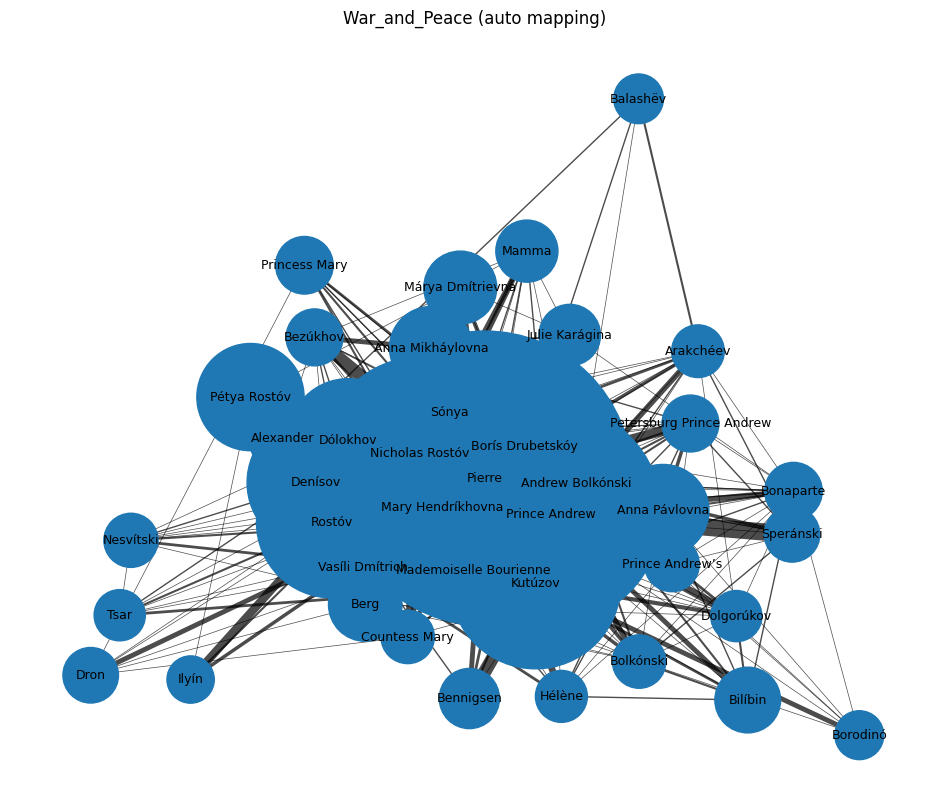

Saved node metrics to: c:\Users\Omen\Documents\GitHub\SecondProject\results\War_and_Peace_auto_node_metrics.csv

Processing c:\Users\Omen\Documents\GitHub\SecondProject\data\The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt as Anna_Karenina
Paragraphs: 7430
Manual mapping CSV found: c:\Users\Omen\Documents\GitHub\SecondProject\results\manual_name_mapping.csv. Will be used if you call apply_manual_mapping().


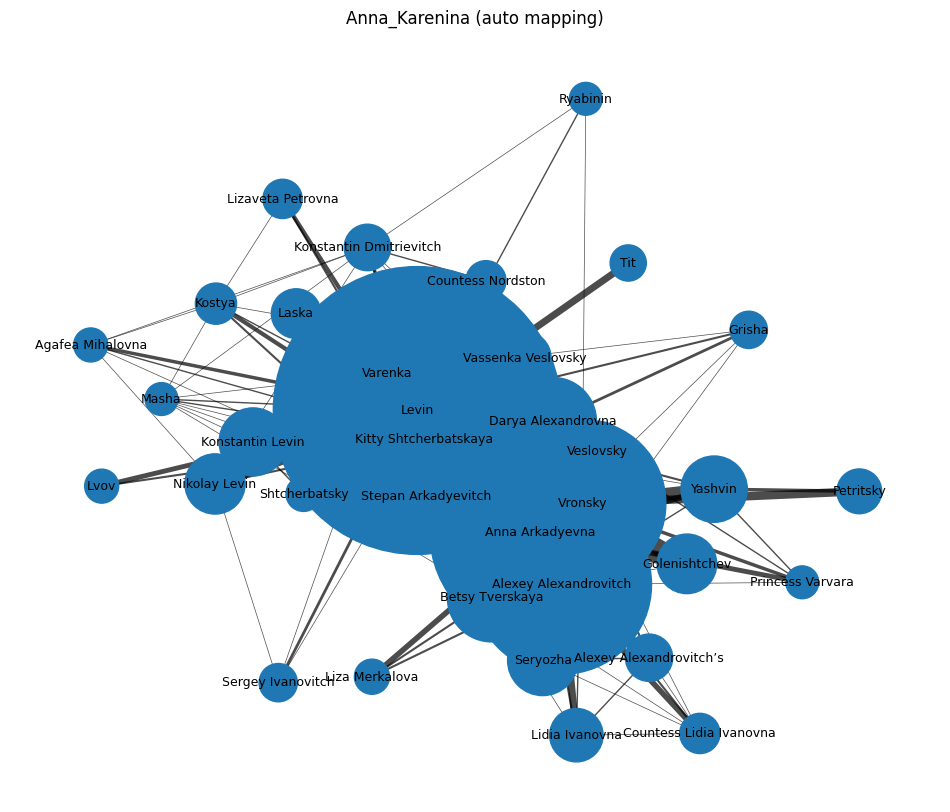

Saved node metrics to: c:\Users\Omen\Documents\GitHub\SecondProject\results\Anna_Karenina_auto_node_metrics.csv

Run complete. If you want to apply manual mapping corrections, edit the file:
c:\Users\Omen\Documents\GitHub\SecondProject\results\manual_name_mapping.csv
Then run the "Apply manual mapping" cell below to recompute graphs and metrics using your canonical names.


In [19]:
# 9) Run pipeline for both books
# Ensure your text files are in the DATA_DIR
DATA_DIR = Path(DATA_DIR)
war_candidates = list(DATA_DIR.glob('*War*Peace*.txt')) + list(DATA_DIR.glob('*war*peace*.txt'))
anna_candidates = list(DATA_DIR.glob('*Anna*Karin*.txt')) + list(DATA_DIR.glob('*Anna*Karenina*.txt'))

if not war_candidates:
    print('No War and Peace candidate found in', DATA_DIR)
if not anna_candidates:
    print('No Anna Karenina candidate found in', DATA_DIR)

war_file = war_candidates[0] if war_candidates else None
anna_file = anna_candidates[0] if anna_candidates else None

results = {}
if war_file:
    results['war'] = run_book(war_file, 'War_and_Peace', top_n_nodes=40)
else:
    print('Please add War and Peace text to data/')

if anna_file:
    results['anna'] = run_book(anna_file, 'Anna_Karenina', top_n_nodes=35)
else:
    print('Please add Anna Karenina text to data/')

print('\nRun complete. If you want to apply manual mapping corrections, edit the file:')
print(results.get('war', {}).get('manual_csv') or results.get('anna', {}).get('manual_csv'))
print('Then run the "Apply manual mapping" cell below to recompute graphs and metrics using your canonical names.')


In [20]:
# 10) Apply manual mapping (after you edit results/manual_name_mapping.csv)
# This cell will load the manual CSV and rebuild graphs/metrics using the manual mapping

def apply_manual_for_all(results_dict):
    recomputed = {}
    for key, res in results_dict.items():
        print('\nApplying manual mapping for', key)
        paragraphs = res['paragraphs']
        manual_map, person_counts_manual, cooc_manual = apply_manual_mapping(res['raw_person_counter'], paragraphs)
        G_manual = build_graph(person_counts_manual, cooc_manual, min_edge_weight=1)
        png_manual = OUTDIR / f"{key}_network_manual.png"
        draw_networkx(G_manual, top_n_nodes=40, title=f"{key} (manual mapping)", savepath=png_manual)
        metrics_manual = compute_and_export_metrics(G_manual, f"{key}_manual")
        recomputed[key] = {
            'manual_map': manual_map,
            'G_manual': G_manual,
            'metrics_manual': metrics_manual,
            'png_manual': png_manual
        }
    return recomputed

# To run this cell, simply execute: recomputed = apply_manual_for_all(results)


In [21]:
# 11) Compare the two networks side-by-side (metrics + visualization)
# This cell expects 'results' (from the run cell) and optionally 'recomputed' (after manual mapping)

comparison_df = []

# Prefer manual metrics if available
use_manual = 'recomputed' in globals()

for key in ['war', 'anna']:
    if key not in results:
        continue
    if use_manual and key in recomputed:
        metrics = recomputed[key]['metrics_manual']
        tag = key + '_manual'
    else:
        metrics = results[key]['metrics_auto']
        tag = key + '_auto'

    # top 10 by weighted_degree
    top10 = metrics.head(10).copy()
    top10['book'] = tag
    comparison_df.append(top10)

if comparison_df:
    comp = pd.concat(comparison_df, ignore_index=True)
    # Save combined CSV
    comp_csv = OUTDIR / 'comparison_top10_metrics.csv'
    comp.to_csv(comp_csv, index=False)
    print('Saved comparison table to', comp_csv)
    try:
        from IPython.display import display
        display(comp)
    except Exception:
        print(comp)

# Visualizations: show the two PNGs (auto or manual) sequentially
for key in ['war', 'anna']:
    if use_manual and key in recomputed:
        path = recomputed[key]['png_manual']
    else:
        path = OUTDIR / f"{key}_network_auto.png"
    print('\nImage for', key, ':', path)
    
    try:
        from IPython.display import Image, display
        display(Image(str(path)))
    except Exception:
        print('Cannot display image inline; find it at', path)


Saved comparison table to c:\Users\Omen\Documents\GitHub\SecondProject\results\comparison_top10_metrics.csv


,character,degree,weighted_degree,betweenness,mentions,book
0,Pierre,201,675,0.123234,1125,war_auto
1,Prince Andrew,134,560,0.056343,633,war_auto
2,Nicholas Rostóv,121,491,0.069212,478,war_auto
3,Mary Hendríkhovna,84,410,0.034864,451,war_auto
4,Kutúzov,125,338,0.061191,377,war_auto
5,Rostóv,98,253,0.051434,294,war_auto
6,Sónya,57,242,0.027425,267,war_auto
7,Andrew Bolkónski,69,227,0.023250,176,war_auto
8,Denísov,57,189,0.026083,246,war_auto
9,Borís Drubetskóy,70,187,0.030937,156,war_auto



Image for war : c:\Users\Omen\Documents\GitHub\SecondProject\results\war_network_auto.png


FileNotFoundError: No such file or directory: 'c:\Users\Omen\Documents\GitHub\SecondProject\results\war_network_auto.png'

FileNotFoundError: No such file or directory: 'c:\Users\Omen\Documents\GitHub\SecondProject\results\war_network_auto.png'

<IPython.core.display.Image object>


Image for anna : c:\Users\Omen\Documents\GitHub\SecondProject\results\anna_network_auto.png


FileNotFoundError: No such file or directory: 'c:\Users\Omen\Documents\GitHub\SecondProject\results\anna_network_auto.png'

FileNotFoundError: No such file or directory: 'c:\Users\Omen\Documents\GitHub\SecondProject\results\anna_network_auto.png'

<IPython.core.display.Image object>

## Final notes

- After running the notebook once, a template manual mapping CSV will be written to `results/manual_name_mapping.csv` containing the most frequent raw extracted names. Edit that CSV to supply `canonical_name` values for rows where you'd like to merge variants (for example mapping `Pierre` -> `Pierre Bezukhov`).
- Once edited, run the **Apply manual mapping** cell to rebuild the graphs and export updated metrics/PNGs.
- The notebook exports CSVs for node metrics and a combined comparison table in the `results/` folder for inclusion in your write-up.

If you want I can also (in a follow-up) produce a shorter "professor-style" narrative with a few interpretation cells and a cleaned-up figure layout.